## TODO

In [1]:
import torch
import torch.nn as nn
import os, sys
import re
import numpy as np
import glob
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# Add project root (one level up) to Python path 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from models.parity_rnn import ParityRNN
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

torch.manual_seed(42)

In [2]:
# Hyperparameters
hidden_size = 100       # number of hidden ReLU units
input_size = 2          # one-hot binary input
output_size = 2         # one-hot parity output
learning_rate = 0.06    # SGD learning rate
batch_size = 128        # training batch size
num_epochs = 1000       # number of training epochs
clip_norm = None        # no gradient clipping
VAL_SEQ_LEN = 100

# Optimizer example
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ParityRNN(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0, weight_decay=0.0)
criterion = nn.MSELoss()


In [3]:
# Load training data from .npz
train_data = np.load('../data/training/train_data.npz', allow_pickle=True)
train_seqs = train_data['X']
train_labels = train_data['Y']
train_losses = []

val_files = glob.glob(os.path.join("../data/validation/", 'val_data_*.npz'))
val_files = sorted(
    val_files,
    key=lambda p: int(re.search(r'(\d+)(?=\.npz$)', os.path.basename(p)).group(1))
)
val_numbers = [int(re.search(r'(\d+)(?=\.npz$)', os.path.basename(p)).group(1)) for p in val_files]

val_data = [np.load(f, allow_pickle=True) for f in val_files]
val_seqs = [d['X'] for d in val_data] 
val_labels = [d['Y'] for d in val_data]
val_losses = []

one-hot encodings

In [4]:
def one_hot_seq(seq):
    tens = []
    for bits in seq:
        L = len(bits)
        t = torch.zeros(L, input_size)
        for i, b in enumerate(bits):
            t[i, b] = 1.0
        tens.append(t)
    return tens

In [5]:
train_tensors = one_hot_seq(train_seqs)
train_labels_tensor = torch.LongTensor(train_labels)

val_tensors = [one_hot_seq(val_seq) for val_seq in val_seqs]
val_labels_tensor = [torch.LongTensor(val_label) for val_label in val_labels]

In [6]:
def train_parity_rnn(n):
  model.train()
  total_train_loss = 0.0

  perm = torch.randperm(n)
  for i in range(0, n, batch_size):
      idx = perm[i : i+batch_size]
      batch_xs = [train_tensors[j].to(device) for j in idx.tolist()]
      batch_labels = train_labels_tensor[idx].to(device)

      packed_x = pack_sequence(batch_xs, enforce_sorted=False).to(device)

      logits, _ = model(packed_x)
        
      target = torch.zeros_like(logits)
      target[torch.arange(logits.size(0)), batch_labels] = 1.0

      # MSE on final output only
      loss = criterion(logits, target)

      optimizer.zero_grad()
      loss.backward()

      clip_value = 0.5
      torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)

      # Update weights
      optimizer.step()

      # loss.item() is already averaged over batch_size
      total_train_loss += loss.item() * batch_labels.size(0)

  return total_train_loss

In [7]:
def validate_model():
    model.eval()
    total_val_losses = []
    total_correct = []
    for num, v in enumerate(val_seqs):
        total_val_loss = 0.0
        correct = 0
        
        with torch.no_grad():        
            for i in range(0, len(v), batch_size):
                end_idx = min(i + batch_size, len(v))
                batch_xs = [val_tensors[num][j].to(device) for j in range(i, end_idx)]
                batch_labels = val_labels_tensor[num][i:end_idx].to(device)
                
                packed_x = pack_sequence(batch_xs, enforce_sorted=False).to(device)
                logits, _ = model(packed_x)
                
                target = torch.zeros_like(logits)
                target[torch.arange(logits.size(0)), batch_labels] = 1.0
                
                loss = criterion(logits, target)
                total_val_loss += loss.item() * batch_labels.size(0)
                
                # Calculate accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == batch_labels).sum().item()
        
        total_val_losses.append(total_val_loss)
        total_correct.append(correct)

    return total_val_losses, total_correct

In [8]:
def validate_model_optimized():
    """Optimized validation maintaining separate results per sequence length"""
    model.eval()
    
    results = {
        'losses': [],
        'accuracies': [],
    }
    
    with torch.no_grad():
        for val_idx, (val_tensor_list, val_label_tensor) in enumerate(zip(val_tensors, val_labels_tensor)):
            total_loss = 0.0
            correct = 0
            
            # Adaptive batch size based on sequence length
            seq_length = val_numbers[val_idx]
            if seq_length <= 25:
                batch_size_val = 100  # Process all at once for short sequences
            elif seq_length <= 50:
                batch_size_val = 50   # Two batches
            else:
                batch_size_val = 25   # Four batches for longer sequences
            
            for i in range(0, 100, batch_size_val):
                end_idx = min(i + batch_size_val, 100)
                batch_xs = [val_tensor_list[j].to(device) for j in range(i, end_idx)]
                batch_labels = val_label_tensor[i:end_idx].to(device)
                
                packed_x = pack_sequence(batch_xs, enforce_sorted=False)
                logits, _ = model(packed_x)
                
                target = torch.zeros_like(logits)
                target.scatter_(1, batch_labels.unsqueeze(1), 1.0)
                
                loss = criterion(logits, target)
                total_loss += loss.item() * len(batch_labels)
                correct += (torch.argmax(logits, dim=1) == batch_labels).sum().item()
            
            # Store results - divide by 100 for average loss
            results['losses'].append(total_loss)  # Average loss per sample
            results['accuracies'].append(correct)
    
    return results

In [9]:
# add to print statement if you want to see validation accuracy in real time while training

def print_val_summary(avg_val_loss, val_accuracy):
    """Efficient one-liner using list comprehension"""
    return ' '.join([
        f"| Val({val_numbers[i]}) - Loss: {loss:.4f} & Acc: {acc:.3f}"
        for i, (loss, acc) in enumerate(zip(avg_val_loss, val_accuracy))
    ])

In [10]:
n = len(train_seqs)
m = VAL_SEQ_LEN

for epoch in range(1,1001):
    total_train_loss = train_parity_rnn(n)
    val_results = validate_model_optimized()
    total_val_loss, correct = val_results['losses'], val_results['accuracies']
    avg_train_loss = total_train_loss / n
    train_losses.append((avg_train_loss, epoch))
    avg_val_loss = [l / m for l in total_val_loss]
    val_losses.append([(avl, epoch) for avl in avg_val_loss])
    val_accuracy = [c / m for c in correct]
    if epoch % 10 == 0:
        print(f"Epoch {epoch:4d} | Train Loss: {avg_train_loss:.4f} {print_val_summary(avg_val_loss, val_accuracy)}")

Epoch   10 | Train Loss: 0.2509 | Val(25) - Loss: 0.2483 & Acc: 0.560 | Val(50) - Loss: 0.2503 & Acc: 0.490 | Val(100) - Loss: 0.2493 & Acc: 0.510 | Val(250) - Loss: 0.2501 & Acc: 0.480 | Val(1000) - Loss: 0.2509 & Acc: 0.520 | Val(2500) - Loss: 0.2491 & Acc: 0.560 | Val(10000) - Loss: 0.2492 & Acc: 0.510
Epoch   20 | Train Loss: 0.2511 | Val(25) - Loss: 0.2495 & Acc: 0.520 | Val(50) - Loss: 0.2503 & Acc: 0.500 | Val(100) - Loss: 0.2497 & Acc: 0.520 | Val(250) - Loss: 0.2504 & Acc: 0.490 | Val(1000) - Loss: 0.2509 & Acc: 0.430 | Val(2500) - Loss: 0.2497 & Acc: 0.530 | Val(10000) - Loss: 0.2500 & Acc: 0.510
Epoch   30 | Train Loss: 0.2508 | Val(25) - Loss: 0.2489 & Acc: 0.570 | Val(50) - Loss: 0.2501 & Acc: 0.500 | Val(100) - Loss: 0.2494 & Acc: 0.510 | Val(250) - Loss: 0.2504 & Acc: 0.480 | Val(1000) - Loss: 0.2511 & Acc: 0.470 | Val(2500) - Loss: 0.2496 & Acc: 0.520 | Val(10000) - Loss: 0.2496 & Acc: 0.520
Epoch   40 | Train Loss: 0.2505 | Val(25) - Loss: 0.2503 & Acc: 0.460 | Val(50)

[[(0.24675260484218597, 1), (0.25040194392204285, 1), (0.25034336373209953, 1), (0.24982237815856934, 1), (0.25082339718937874, 1), (0.24761847034096718, 1), (0.24960907548666, 1)], [(0.2538294196128845, 2), (0.2521243616938591, 2), (0.253883246332407, 2), (0.25064074248075485, 2), (0.24958313256502151, 2), (0.25020257383584976, 2), (0.25204237923026085, 2)], [(0.24536846578121185, 3), (0.25048068165779114, 3), (0.24863024801015854, 3), (0.2506069988012314, 3), (0.25197234004735947, 3), (0.2481934204697609, 3), (0.2492276355624199, 3)], [(0.24914316833019257, 4), (0.2506163492798805, 4), (0.25030600652098656, 4), (0.25002530962228775, 4), (0.25007596239447594, 4), (0.24883601814508438, 4), (0.24984131380915642, 4)], [(0.24695922434329987, 5), (0.25054023414850235, 5), (0.24894415587186813, 5), (0.25050099194049835, 5), (0.25138284265995026, 5), (0.24875081703066826, 5), (0.2494402527809143, 5)], [(0.24857234954833984, 6), (0.25034231692552567, 6), (0.2495330609381199, 6), (0.2498674280

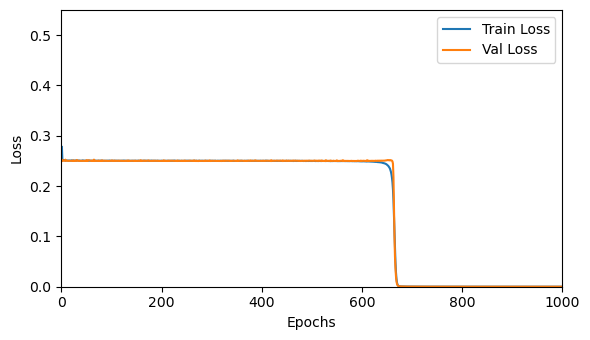

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

# Specifically using validation set of length 50

train_losses_array = np.array(train_losses)
print(val_losses)
val_losses_array = np.array([v[1] for v in val_losses])

# Extract epochs and losses
train_epochs = train_losses_array[:, 1]
train_values = train_losses_array[:, 0]

val_epochs = val_losses_array[:, 1]
val_values = val_losses_array[:, 0]

# Create the plot
plt.figure(figsize=(6, 3.5))
plt.plot(train_epochs, train_values, label="Train Loss")
plt.plot(val_epochs, val_values, label="Val Loss")

# Axis labels and limits to mimic style
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(0, 1000)
plt.ylim(0, 0.55)

# Optional grid and legend
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig('../figures/training_validation_losses_50.png', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white')
plt.show()

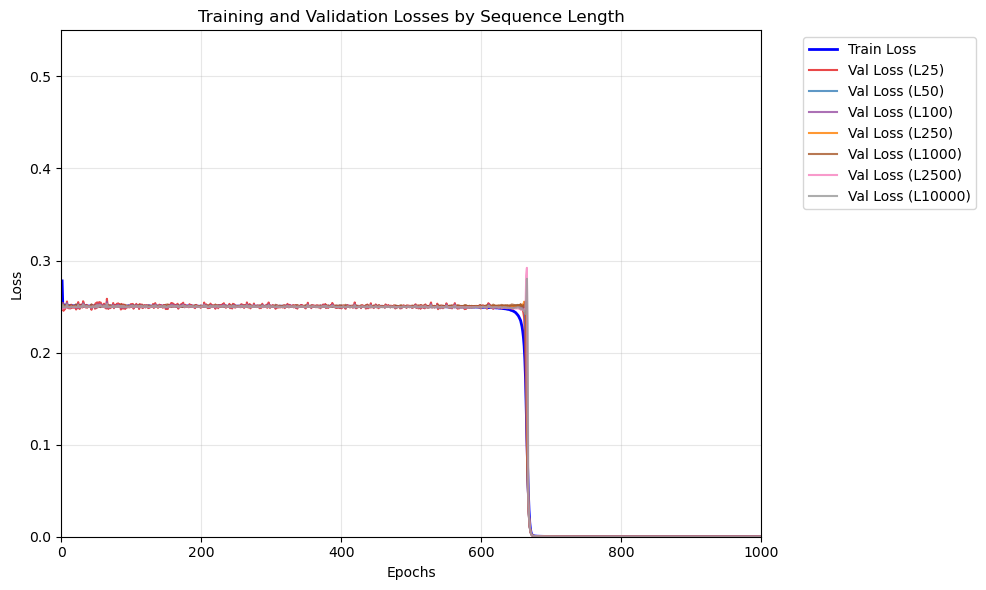

<Figure size 640x480 with 0 Axes>

In [12]:
# using ALL validation sets

train_losses_array = np.array(train_losses)
train_epochs = train_losses_array[:, 1]
train_values = train_losses_array[:, 0]

# Process validation losses (which are stored as lists of tuples per epoch)
val_losses_by_length = {}

# Extract validation losses for each sequence length
for epoch_idx, epoch_val_data in enumerate(val_losses):
    epoch_num = epoch_idx + 1  # Assuming epochs start from 1
    
    for val_idx, (val_loss, _) in enumerate(epoch_val_data):
        length = val_numbers[val_idx]
        
        if length not in val_losses_by_length:
            val_losses_by_length[length] = {'epochs': [], 'losses': []}
        
        val_losses_by_length[length]['epochs'].append(epoch_num)
        val_losses_by_length[length]['losses'].append(val_loss)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_epochs, train_values, label="Train Loss", linewidth=2, color='blue')

# Plot validation losses for each sequence length
colors = plt.cm.Set1(np.linspace(0, 1, len(val_numbers)))  # Different colors for each length

for i, length in enumerate(sorted(val_numbers)):
    if length in val_losses_by_length:
        epochs = val_losses_by_length[length]['epochs']
        losses = val_losses_by_length[length]['losses']
        plt.plot(epochs, losses, 
                label=f"Val Loss (L{length})", 
                linewidth=1.5, 
                color=colors[i],
                alpha=0.8)

# Formatting
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(0, 1000)
plt.ylim(0, 0.55)
plt.title("Training and Validation Losses by Sequence Length")

# Legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


plt.savefig('../figures/training_validation_losses_all.png', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white')
plt.show()

In [13]:
checkpoint = {
    "epoch": epoch,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_losses": train_losses,
    "val_losses": val_losses,
}
torch.save(checkpoint, "../models/checkpoints/parity_rnn_checkpoint.pt")
